In [1]:
%load_ext autoreload
%autoreload 2

# Import Classes

In [2]:
import sys
import os


sys.path.append("..")

In [3]:
import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm


import torch

from src.utils import confoundSplit, confoundSplitNumbers, confoundSplitDF

from src.NeuralModel import TransformerDataset
from src.NeuralSingleLabelModel import NeuralSingleLabelModel
from src.data_process import load_wls_adress_AddDomain

from sklearn.preprocessing import MultiLabelBinarizer

# (1/2: testing) Total Reorg -> Use Cross Entropy Loss

## Data

### Add Domain Label

In [4]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

### Data Mix and Split

In [5]:
# combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)

combination = (0.201, 0.7010000000000001, 0.501, 1.4000000000000001, 4)
ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                      df0_label='label', df1_label='label',
                      p_pos_train_z0=combination[0], 
                      p_pos_train_z1 = combination[1], 
                      p_mix_z1 = combination[2], 
                      alpha_test = combination[3],
                      train_test_ratio = combination[4],
                      random_state=13
                           )

In [6]:

df_train = pd.concat([ret['sample_df0_train'][['text', 'label']], ret['sample_df1_train'][['text', 'label']]], ignore_index=True)


df_test = pd.concat([ret['sample_df0_test'][['text', 'label']], ret['sample_df1_test'][['text', 'label']]], ignore_index=True)


In [7]:
X_train = df_train['text']
y_train = df_train[['label']]


X_test = df_test['text']
y_test = df_test[['label']]


In [8]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))


718
718
179
179


## Dataset and DataLoader

In [9]:
from src.NeuralModel import TransformerDataset

In [10]:
from torch.utils.data import DataLoader

In [11]:
dataset = TransformerDataset(
            X=X_train,
            y=y_train,
            pretrained="bert-base-uncased",
            max_length=120,
        )
dataloader = DataLoader(dataset, shuffle=True, batch_size=50)


In [12]:
batch = next(iter(dataloader))

In [13]:
batch

{'input_ids': tensor([[ 101, 2673, 1045,  ...,    0,    0,    0],
         [ 101, 2027, 1005,  ...,    0,    0,    0],
         [ 101, 2092, 1996,  ...,    0,    0,    0],
         ...,
         [ 101, 2092, 1996,  ..., 1037, 3797,  102],
         [ 101, 8529, 4268,  ..., 1996, 2879,  102],
         [ 101, 2092, 2023,  ..., 1005, 1055,  102]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([[0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
     

In [14]:
batch = {k: v.to("cuda:0") for k, v in batch.items()}

## Load Model

In [15]:
num_labels = 2

pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 10
problem_type = 'single_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 1e-5
grad_norm = 1.0
balance_weights = False



In [16]:

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm
model_config["problem_type"] = problem_type

In [17]:
model = NeuralSingleLabelModel(**model_config)

In [18]:
model

In [19]:
model.load_pretrained()

In [ ]:
model.model.to("cuda:0")

## Load Model

In [21]:
batch['labels'] = batch['labels'].type(torch.long)

In [22]:
outputs = model.model(**batch)

In [23]:
criterion = torch.nn.CrossEntropyLoss()

In [24]:
criterion(outputs.logits, batch['labels'].squeeze(1))

tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward0>)

## Format Prediction Output

In [25]:
softmax = torch.nn.Softmax(dim=1)


In [26]:
logits = outputs.logits

In [27]:
probs = softmax(logits)

In [28]:
probs

tensor([[0.4363, 0.5637],
        [0.5388, 0.4612],
        [0.4927, 0.5073],
        [0.5272, 0.4728],
        [0.4782, 0.5218],
        [0.4879, 0.5121],
        [0.5022, 0.4978],
        [0.5046, 0.4954],
        [0.5089, 0.4911],
        [0.4629, 0.5371],
        [0.4768, 0.5232],
        [0.4667, 0.5333],
        [0.4621, 0.5379],
        [0.5081, 0.4919],
        [0.4991, 0.5009],
        [0.4763, 0.5237],
        [0.4394, 0.5606],
        [0.4707, 0.5293],
        [0.4982, 0.5018],
        [0.5040, 0.4960],
        [0.4554, 0.5446],
        [0.5236, 0.4764],
        [0.5244, 0.4756],
        [0.4850, 0.5150],
        [0.4456, 0.5544],
        [0.4622, 0.5378],
        [0.5042, 0.4958],
        [0.3888, 0.6112],
        [0.4532, 0.5468],
        [0.4695, 0.5305],
        [0.5223, 0.4777],
        [0.4502, 0.5498],
        [0.4941, 0.5059],
        [0.4695, 0.5305],
        [0.4684, 0.5316],
        [0.4815, 0.5185],
        [0.5258, 0.4742],
        [0.4800, 0.5200],
        [0.5

In [43]:
c1 = torch.nn.NLLLoss()

In [44]:
c1(torch.log(probs), batch['labels'].squeeze(1))

tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward0>)

In [45]:
c2 = torch.nn.BCELoss()

In [46]:
c2(probs[:,1], batch['labels'].squeeze(1).type(torch.float))

tensor(0.7080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [63]:
c2 = torch.nn.BCEWithLogitsLoss()

In [116]:
c2(outputs.logits[:,1], batch['labels'].squeeze(1).type(torch.float))

tensor(0.6820, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [115]:
np.average([0.6820, 0.7647])

0.72335

In [ ]:
metrics.f1_score(y_true=y_test.values, y_pred=y_pred, average=average_f1)

# (2/2: applying) Use Cross Entropy Loss: Apply

## Data

### Add Domain Label

In [29]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

In [30]:
df_wls_merge['domain_index'].value_counts()

0    1360
Name: domain_index, dtype: int64

In [31]:
df_adress['domain_index'].value_counts()

1    548
Name: domain_index, dtype: int64

### Data Mix and Split

In [32]:
# combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)

combination = (0.201, 0.7010000000000001, 0.501, 1.4000000000000001, 4)
ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                      df0_label='label', df1_label='label',
                      p_pos_train_z0=combination[0], 
                      p_pos_train_z1 = combination[1], 
                      p_mix_z1 = combination[2], 
                      alpha_test = combination[3],
                      train_test_ratio = combination[4],
                      random_state=13
                           )

In [33]:

df_train = pd.concat([ret['sample_df0_train'][['text', 'label','domain_index']], ret['sample_df1_train'][['text', 'label','domain_index']]], ignore_index=True)


df_test = pd.concat([ret['sample_df0_test'][['text', 'label','domain_index']], ret['sample_df1_test'][['text', 'label','domain_index']]], ignore_index=True)

In [34]:
X_train = df_train['text']
y_train = df_train[['label']]
y_domain_train = df_train[['domain_index']]

X_test = df_test['text']
y_test = df_test[['label']]
y_domain_test = df_test[['domain_index']]

In [35]:
print(len(X_train))
print(len(y_train))
print(len(y_domain_train))

print(len(X_test))
print(len(y_test))
print(len(y_domain_test))

718
718
718
179
179
179


In [36]:
y_domain_train['domain_index'].value_counts()

0    359
1    359
Name: domain_index, dtype: int64

In [37]:
y_domain_test['domain_index'].value_counts()

0    90
1    89
Name: domain_index, dtype: int64

## Load Model

In [38]:
num_labels = 2

num_domain_labels = 2
# domain_labels = 'domain_index'

pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 10
problem_type = 'multi_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 1e-5
grad_norm = 1.0
balance_weights = False



In [39]:

model_config = {}
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm
# model_config["domain_labels"] = ["domain"]
model_config["num_domain_labels"] = num_domain_labels

In [17]:
model = GradientReverseModel(**model_config)

In [18]:
model.load_pretrained()

## Test `trainModel()`

In [22]:
random.seed(12)
np.random.seed(12)
torch.manual_seed(33)
torch.cuda.manual_seed(33)

model.trainModel(X=X_train, y=y_train,  y_domain=y_domain_train, device='cuda:0')

  0%|                                                | 0/150 [00:35<?, ?it/s]


## Test `trainModelWithTest()`

In [23]:
random.seed(12)
np.random.seed(12)
torch.manual_seed(33)
torch.cuda.manual_seed(33)


model.trainModelWithTest(X=X_train, y=y_train, y_domain_train=y_domain_train, X_test=X_test, y_test=y_test, y_domain_test=y_domain_test,
                         device='cuda:0')

  0%|                                                | 0/150 [00:37<?, ?it/s]


In [24]:
import matplotlib.pyplot as plt

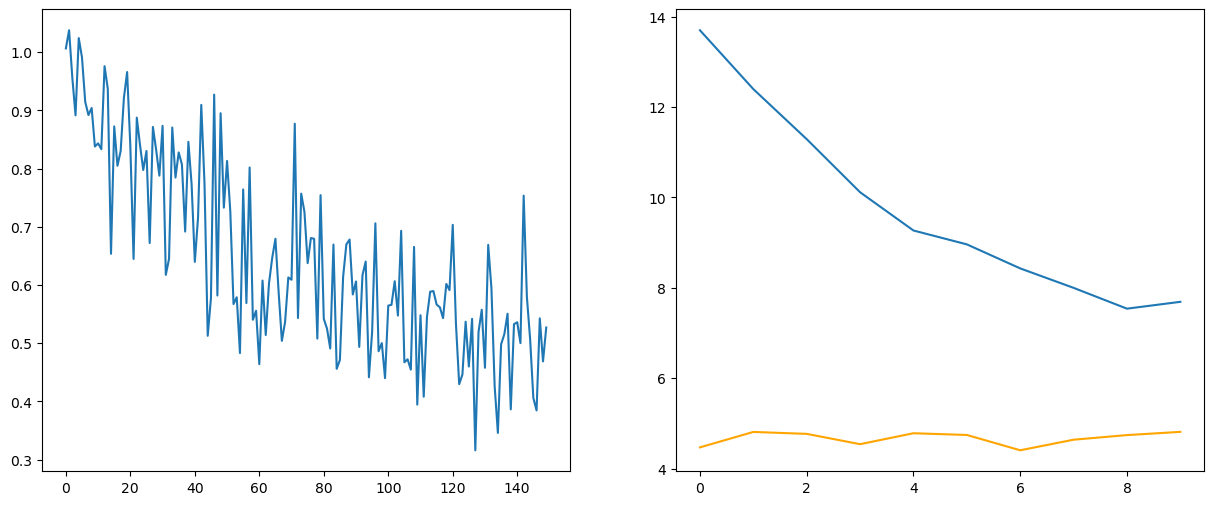

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(model.loss_steps)
ax[1].plot(model.loss_epochs)
ax[1].plot(model.loss_test_total_epochs, c='orange')


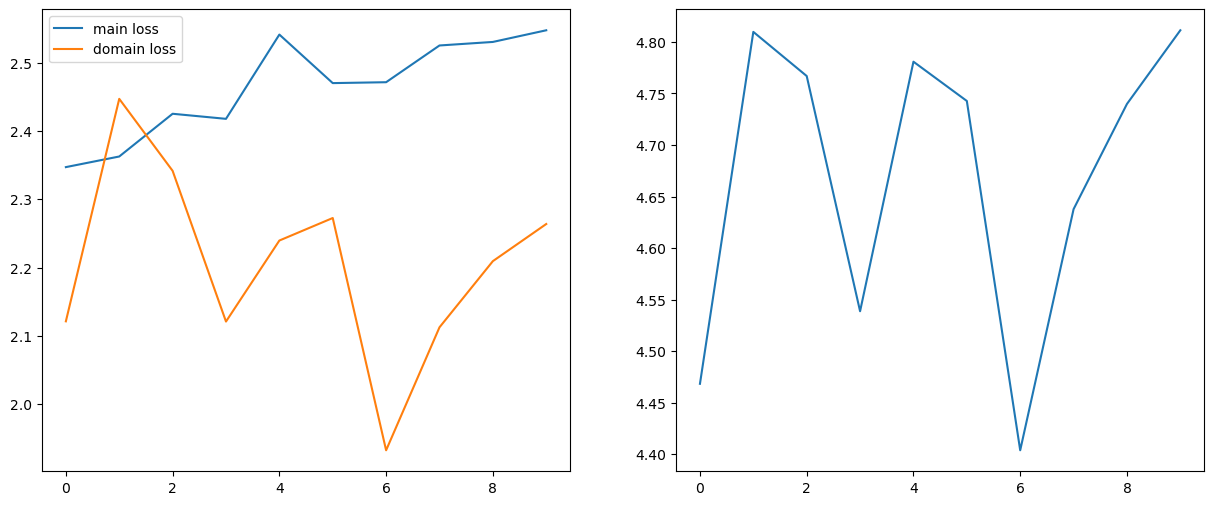

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(model.loss_test_main_epochs, label='main loss')
ax[0].plot(model.loss_test_domain_epochs, label='domain loss')
ax[1].plot(model.loss_test_total_epochs, label='totalloss')
ax[0].legend()

Text(0.5, 1.0, 'epoch=10, lr=1e-05')

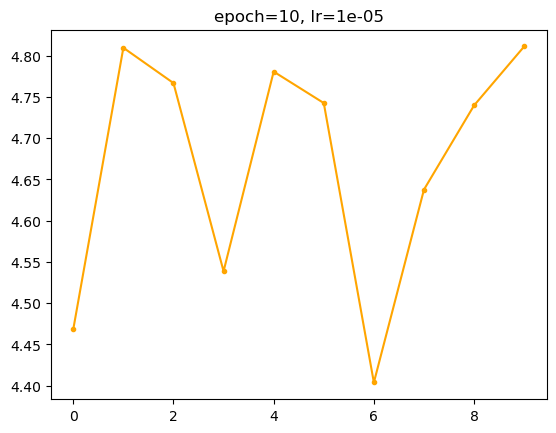

In [27]:
plt.plot(model.loss_test_total_epochs, c='orange', marker=".")
plt.title(f"epoch={num_epochs}, lr={lr}")

## Test `predict()`

In [20]:
y_main_pred, y_main_prob, y_domain_pred, y_domain_prob = model.predict(X=X_test, device="cuda:0")




  0%|                                                  | 0/4 [00:00<?, ?it/s]


In [22]:
y_main_prob

,0,1
0,0.580412,0.419588
1,0.447642,0.552358
2,0.408299,0.591701
3,0.534573,0.465427
4,0.412160,0.587840
...,...,...
174,0.552773,0.447227
175,0.513744,0.486256
176,0.447516,0.552484
177,0.531971,0.468029


In [24]:
loss = torch.nn.NLLLoss()

In [39]:
loss(torch.log(torch.tensor(y_main_prob.values)), torch.tensor(y_test.values).squeeze(1))

tensor(0.6967)

In [40]:
from sklearn import metrics

In [42]:
y_main_prob

,0,1
0,0.580412,0.419588
1,0.447642,0.552358
2,0.408299,0.591701
3,0.534573,0.465427
4,0.412160,0.587840
...,...,...
174,0.552773,0.447227
175,0.513744,0.486256
176,0.447516,0.552484
177,0.531971,0.468029


In [73]:
target = np.random.randint(0,2,[10,3])
target

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 1],
       [0, 1, 0],
       [1, 0, 1]])

In [74]:
m = torch.nn.Softmax(dim=1)

inputs = m(torch.rand(10,3))
inputs

tensor([[0.3214, 0.3963, 0.2823],
        [0.3106, 0.2702, 0.4192],
        [0.4731, 0.3043, 0.2227],
        [0.3917, 0.3914, 0.2169],
        [0.3091, 0.4576, 0.2332],
        [0.4456, 0.2112, 0.3431],
        [0.2339, 0.3911, 0.3750],
        [0.3559, 0.2801, 0.3640],
        [0.3805, 0.2213, 0.3982],
        [0.3700, 0.2728, 0.3572]])

In [75]:
metrics.roc_auc_score(y_true=target, y_score=inputs)

0.33499999999999996

In [85]:
label_binarizer.transform([0,1,2,9])

array([[1, 0],
       [0, 1],
       [0, 0],
       [0, 0]])

In [97]:
from sklearn.preprocessing import MultiLabelBinarizer

In [134]:
reversed(range(2))

In [147]:
multilabel_binarizer = MultiLabelBinarizer(classes=range(2))

In [ ]:
multilabel_binarizer.fit_transform(y_test.values)

In [157]:
metrics.average_precision_score(y_true=multilabel_binarizer.fit_transform(y_test.values),
                      y_score=y_main_prob
                     )

0.5410788717524644

In [159]:
metrics.f1_score(y_true=y_test.values,
                      y_pred=y_main_pred
                     )

0.5251396648044692

In [5]:
df_wls_merge[['domain_WLS','domain_ADRESS']] = [1,0]

In [6]:
df_adress[['domain_WLS','domain_ADRESS']] = [0,1]

In [7]:

combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)
ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                            train_test_ratio = combination[4],
                           )

In [8]:
ret

{'n_df0_train_pos': 131,
 'n_df0_test_pos': 53,
 'n_df0_train_neg': 524,
 'n_df0_test_neg': 111,
 'n_df1_train_pos': 169,
 'n_df1_test_pos': 22,
 'n_df1_train_neg': 112,
 'n_df1_test_neg': 47,
 'mix_param_dict': {'p_pos_train_z0': 0.201,
  'p_pos_train_z1': 0.6010000000000001,
  'p_pos_train': 0.3214000000000001,
  'p_pos_test': 0.3214000000000001,
  'p_mix_z0': 0.699,
  'p_mix_z1': 0.30100000000000005,
  'alpha_train': 2.9900497512437814,
  'alpha_test': 1.0,
  'p_pos_test_z0': 0.3214000000000001,
  'p_pos_test_z1': 0.3214000000000001,
  'C_y': 0.3214000000000001,
  'C_z': 0.30100000000000005}}

In [9]:
combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)
ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                            train_test_ratio = combination[4],
                           )

In [10]:
ret['stats']

{'n_df0_train_pos': 131,
 'n_df0_test_pos': 53,
 'n_df0_train_neg': 524,
 'n_df0_test_neg': 111,
 'n_df1_train_pos': 169,
 'n_df1_test_pos': 22,
 'n_df1_train_neg': 112,
 'n_df1_test_neg': 47,
 'mix_param_dict': {'p_pos_train_z0': 0.201,
  'p_pos_train_z1': 0.6010000000000001,
  'p_pos_train': 0.3214000000000001,
  'p_pos_test': 0.3214000000000001,
  'p_mix_z0': 0.699,
  'p_mix_z1': 0.30100000000000005,
  'alpha_train': 2.9900497512437814,
  'alpha_test': 1.0,
  'p_pos_test_z0': 0.3214000000000001,
  'p_pos_test_z1': 0.3214000000000001,
  'C_y': 0.3214000000000001,
  'C_z': 0.30100000000000005}}

In [11]:
ret

{'sample_df0_train':            file                                               text  \
 0    2000008541  Let's see. A little boy is in the cookie jar s...   
 1    2000009653  The kid's in the cookie jar. The girl wants hi...   
 2    2000013905  He's going to fall off that stool. And she's r...   
 3    2000000208  Boy going in the cookie jar. Girl laughing at ...   
 4    2000015630  Oh. Mother's doing the work. But she's not pay...   
 ..          ...                                                ...   
 650  2000012299  I see a lady doing washing dishes wiping dishe...   
 651  2000015974  Water falling off outof the sink. Chair fallin...   
 652  2000015047  Water overflowing in the sink. Mother drying d...   
 653  2000001600  Um the little girl is telling the little boy n...   
 654  2000015187  Okay. Everything i see. I see a guy standing o...   
 
        idtlkbnk  age 2011  education  category fluency version, 2011  \
 0    2000008541        73         12                

In [12]:
df0_train = ret['sample_df0_train']

# Multiple Tests for mixing

## Data

### Add Domain Label

In [4]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

In [5]:
df_wls_merge['domain_index'].value_counts()

0    1360
Name: domain_index, dtype: int64

In [6]:
df_adress['domain_index'].value_counts()

1    548
Name: domain_index, dtype: int64

## Model Config

In [7]:
num_labels = 2

num_domain_labels = 2
# domain_labels = 'domain_index'

pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 10
problem_type = 'multi_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 1e-5
grad_norm = 1.0
balance_weights = False



In [8]:

model_config = {}
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm
# model_config["domain_labels"] = ["domain"]
model_config["num_domain_labels"] = num_domain_labels

## 5 Random Runs: Train and Predict

### Get Combinations

In [37]:
n_test = 150  # the number of testing examples; set to None to disable (i.e., get as many examples as possible)
n_test_error = 0

valid_high_combinations = []
valid_full_settings = []
for combination in itertools.product([0.1], 
                                    [0.5], 
                                     np.arange(0.1, 0.999, 0.1),
                                     np.arange(0, 10, 0.1),
                                     [4],
                                     [n_test],
                                     [n_test_error]
                                    ):
    
    ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                        df0_label='label', df1_label='label',

                        p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                        train_test_ratio = combination[4], 
                               n_test=n_test, n_test_error=n_test_error
                       )
   
    if (ret is not None) and (ret['n_df0_train_pos'] >= 10): # valid high combos
        valid_high_combinations.append(combination)
        valid_full_settings.append(ret)
    

In [38]:
len(valid_high_combinations)

69

In [11]:
tmp = []
for s in valid_full_settings:
    tmp.append(s['n_df0_test_pos'] + s['n_df0_test_neg']  + s['n_df1_test_pos'] + s['n_df1_test_neg'])

In [12]:
_mix_z1 = [x[2] for x in valid_high_combinations]
print(min(_mix_z1))
print(max(_mix_z1))
print(sorted(set(_mix_z1)))

0.05
0.45
[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45]


In [13]:
tops = 2
valid_high_combinations = valid_high_combinations[:tops]
valid_full_settings = valid_full_settings[:tops]

### Run Train + Predict

In [14]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['full_setting']=[]
losses_dict['losses'] = []
losses_dict['auroc'] = []
losses_dict['auprc'] = []
losses_dict['f1_at_05'] = []

random.seed(29)

for c,setting in tqdm(zip(valid_high_combinations, valid_full_settings), total=len(valid_high_combinations)):
    losses_dict['combination'].append(c)
    losses_dict['full_setting'].append(setting)
    
    losses = []
    _auroc = []
    _auprc = []    
    _f1_at_05 = []
    
    for i in range(5):
        _rand = random.randint(0,1000)    

        combination = c
        # combination = (0.201, 0.6, 0.3, 1.0, 4)
        # combination = (0.201, 0.7, 0.5, 1.4, 4)
        ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                              df0_label='label', df1_label='label',
                              p_pos_train_z0=combination[0], 
                              p_pos_train_z1 = combination[1], 
                              p_mix_z1 = combination[2], 
                              alpha_test = combination[3],
                              train_test_ratio = combination[4],
                              random_state= _rand,
                              n_test=combination[5],
                              n_test_error=combination[6]
                                   )

        df_train = pd.concat(
                [
                    ret["sample_df0_train"][["text", "label", "domain_index"]],
                    ret["sample_df1_train"][["text", "label", "domain_index"]],
                ],
                ignore_index=True,
            )

        df_test = pd.concat(
                [
                    ret["sample_df0_test"][["text", "label", "domain_index"]],
                    ret["sample_df1_test"][["text", "label", "domain_index"]],
                ],
                ignore_index=True,
            )


        X_train = df_train["text"]
        y_train = df_train[["label"]]
        y_domain_train = df_train[["domain_index"]]

        X_test = df_test["text"]
        y_test = df_test[["label"]]
        y_domain_test = df_test[["domain_index"]]




        model = GradientReverseModel(**model_config)

        model.load_pretrained()

        model.trainModel(
                X=X_train, y=y_train, y_domain=y_domain_train, device="cuda:0"
            )



        y_main_pred, y_main_prob, y_domain_pred, y_domain_prob = model.predict(
                X=X_test, device="cuda:0"
            )

        

        # collect metrics: loss, auroc, auprc, f1
        loss = torch.nn.NLLLoss()

        _loss = loss(
            torch.log(torch.tensor(y_main_prob.values)),
            torch.tensor(y_test.values).squeeze(1),
        )

        losses.append(_loss.item())

        # num_domain_label
        multilabel_binarizer = MultiLabelBinarizer(classes=range(num_labels))

        _auroc.append(
            metrics.roc_auc_score(
                y_true=multilabel_binarizer.fit_transform(y_test.values),
                y_score=y_main_prob,
                average="micro",
            )
        )
        _auprc.append(
            metrics.average_precision_score(
                y_true=multilabel_binarizer.fit_transform(y_test.values),
                y_score=y_main_prob,
                average="micro",
            )
        )
        _f1_at_05.append(metrics.f1_score(y_true=y_test.values, y_pred=y_main_pred))
    
    losses_dict['losses'].append(losses)
    losses_dict['auroc'].append(_auroc)
    losses_dict['auprc'].append(_auprc)
    losses_dict['f1_at_05'].append(_f1_at_05)
    

  0%|          | 0/2 [00:00<?, ?it/s]


  0%|                      | 0/170 [00:39<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:38<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:41<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:41<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:41<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:41<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:41<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:43<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:40<?, ?it/s]

  0%|                        | 0/4 [00:00<?, ?it/s]

  0%|                      | 0/170 [00:41<?, 

## Output Results

In [ ]:
import pickle

In [ ]:
with open("../output/results_varying_alpha_0.pkl", "wb") as f:
    pickle.dump(obj=losses_dict, file=f)

In [ ]:
!ls -lrt output

In [20]:
losses_ls = [losses_dict]

# Results & Make Plots

## Collect from Pickles

In [5]:
import pickle
import numpy as np
import pandas as pd

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
losses_ls = []

for i in ["../output/step103_runExp_SingleLabel/exp_SingleHead_01_05/results.pkl",
          "../output/step103_runExp_SingleLabel/exp_SingleHead_02_04/results.pkl",
          "../output/step103_runExp_SingleLabel/exp_SingleHead_03_06/results.pkl",
          # "../output/step102_runExp_TwoHeads/exp_TwoHeads_01_05/results.pkl",
          # "../output/step102_runExp_TwoHeads/exp_TwoHeads_02_04/results.pkl",
          # "../output/step101_runExp/exp_02_04/results.pkl",
          # "../output/step101_runExp/exp_03_06/results.pkl",
         ]:
    with open(i, "rb") as f:
        _ = pickle.load(f)
    losses_ls.append(_)


In [8]:
_.keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [9]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['losses'] = []

for _dict in losses_ls:
    losses_dict['combination'].extend(_dict['combination'])
    losses_dict['losses'].extend(_dict['losses'])

In [14]:
# with open("output/results_varying_alpha_0.pkl", "rb") as f:
#     losses_0 = pickle.load(f)

# with open("output/results_varying_alpha_1.pkl", "rb") as f:
#     losses_1 = pickle.load(f)

# with open("output/results_varying_alpha_2.pkl", "rb") as f:
#     losses_2 = pickle.load(f)

# losses_dict = {}

# losses_dict['combination'] = []
# losses_dict['losses'] = []

# for _dict in (losses_0, losses_1, losses_2):
#     losses_dict['combination'].extend(_dict['combination'])
#     losses_dict['losses'].extend(_dict['losses'])

In [10]:
losses_dict.keys()

dict_keys(['combination', 'losses'])

## Plots

In [11]:
def getTestPos(c, z):
    ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=c[0], p_pos_train_z1 = c[1], p_mix_z1 = c[2], alpha_test = c[3],

                            train_test_ratio = c[4],
                           )
    if z == "z0":
        
        return ret['mix_param_dict']['p_pos_test_z0']
    elif z == "z1":
        return ret['mix_param_dict']['p_pos_test_z1']

In [27]:
def plotAlphaPmix(losses, alpha_train, key_metric:['auroc', 'auprc','losses','f1_at_05'], logx=False):
    
    

    tmp = pd.DataFrame.from_dict({c:losses[key_metric][idx] for idx,c in enumerate(losses['combination'])},
                                 orient="index"
                                )

    tmp = tmp.reset_index()

    tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

    tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])

    tmp['p_pos_test_z0'] = tmp['index'].apply(lambda x: getTestPos(x,z="z0"))
    tmp['p_pos_test_z1'] = tmp['index'].apply(lambda x: getTestPos(x,z="z1"))



    
    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3)

    g.map_dataframe(sns.lineplot, x="alpha_test", y="value")

    g.map(plt.axvline, x=alpha_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)
    
    if logx:
        plt.xscale('log')
        
    return tmp

In [13]:
def plotAlphaDiffPmix(losses, alpha_diff_train, key_metric:['auroc', 'auprc','losses','f1_at_05']):
    
    

    tmp = pd.DataFrame.from_dict({c:losses[key_metric][idx] for idx,c in enumerate(losses['combination'])},
                                 orient="index"
                                )

    tmp = tmp.reset_index()

    tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

    tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])

    tmp['p_pos_test_z0'] = tmp['index'].apply(lambda x: getTestPos(x,z="z0"))
    tmp['p_pos_test_z1'] = tmp['index'].apply(lambda x: getTestPos(x,z="z1"))

    tmp['p_test_diff'] = tmp['p_pos_test_z1'] - tmp['p_pos_test_z0']



    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3)

    g.map_dataframe(sns.lineplot, x="p_test_diff", y="value")

    g.map(plt.axvline, x=alpha_diff_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)

    return tmp

### Setting 0: 0.1 vs 0.5

In [14]:
losses_ls[0].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [15]:
losses_ls[0]['combination'][:2]

[(0.1, 0.5, 0.1, 1.5, 4, 150, 0), (0.1, 0.5, 0.1, 1.6, 4, 150, 0)]

<Figure size 864x720 with 0 Axes>

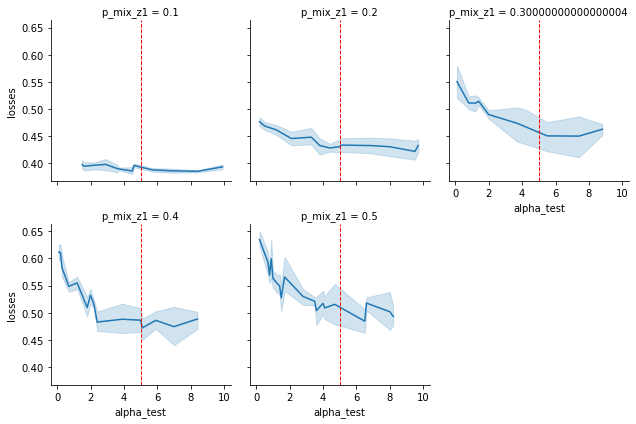

In [40]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='losses')

<Figure size 864x720 with 0 Axes>

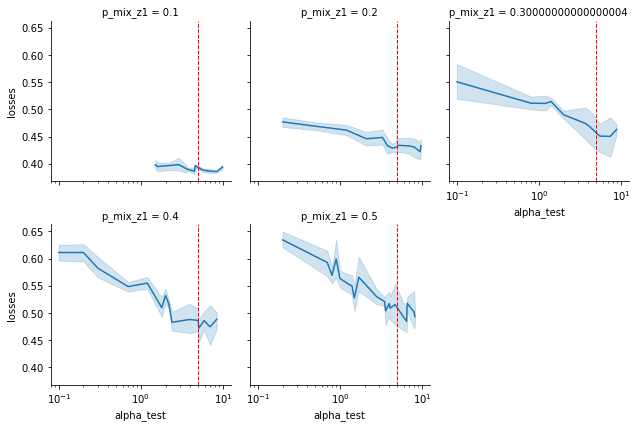

In [41]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

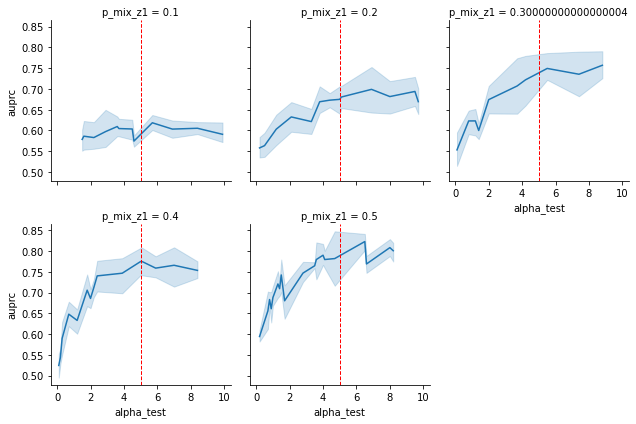

In [42]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

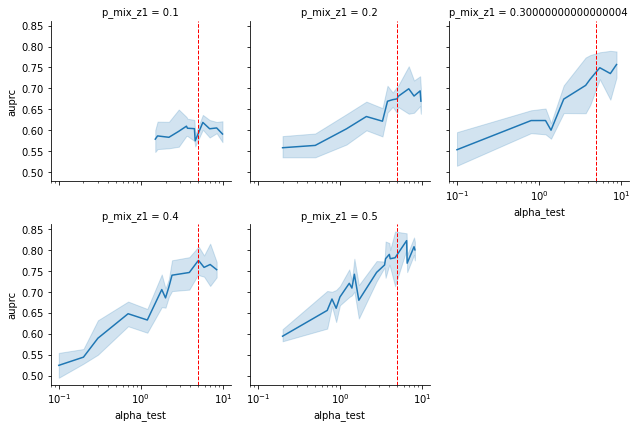

In [43]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

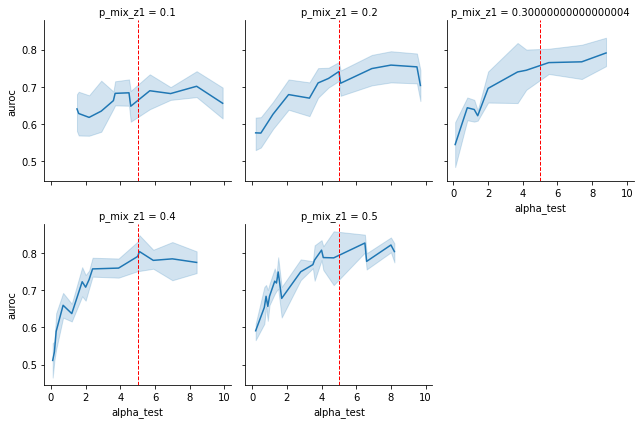

In [44]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

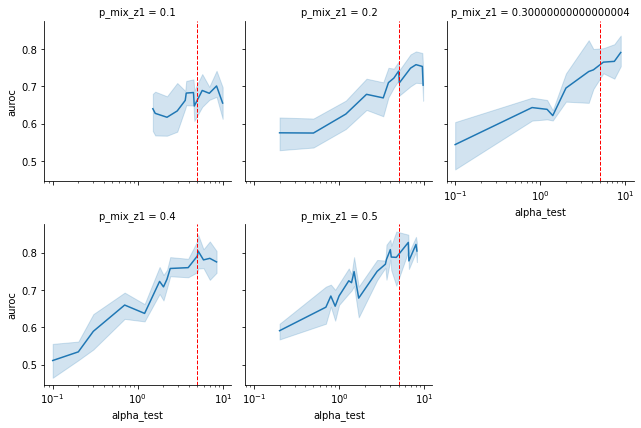

In [45]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

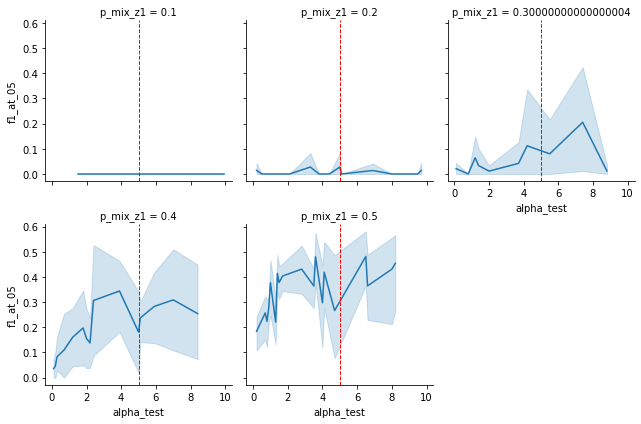

In [46]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='f1_at_05')

<Figure size 864x720 with 0 Axes>

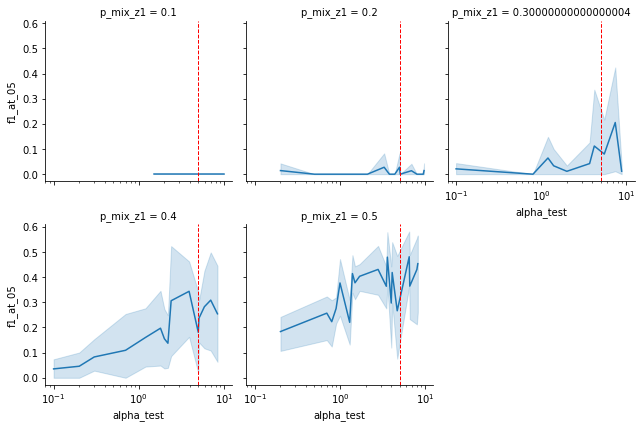

In [47]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=5, key_metric='f1_at_05', logx=True)

### Setting 1: 0.2 vs 0.4

<Figure size 864x720 with 0 Axes>

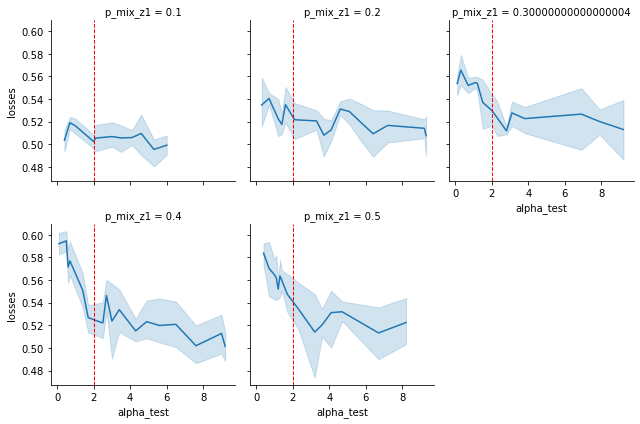

In [48]:
tmp = plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='losses')

<Figure size 864x720 with 0 Axes>

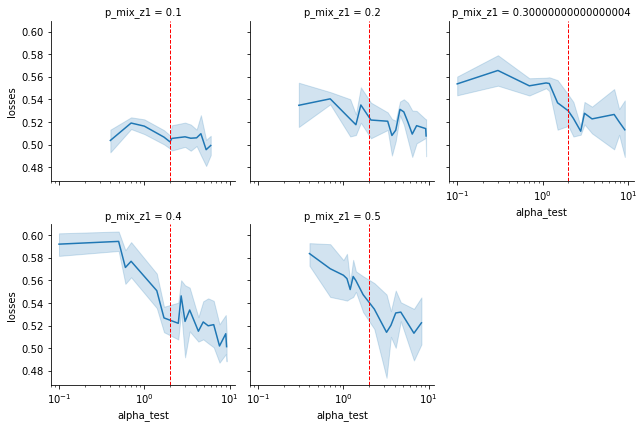

In [49]:
tmp = plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

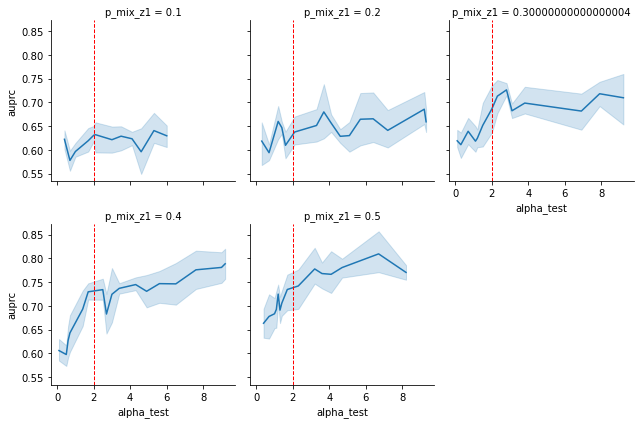

In [50]:
tmp = plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

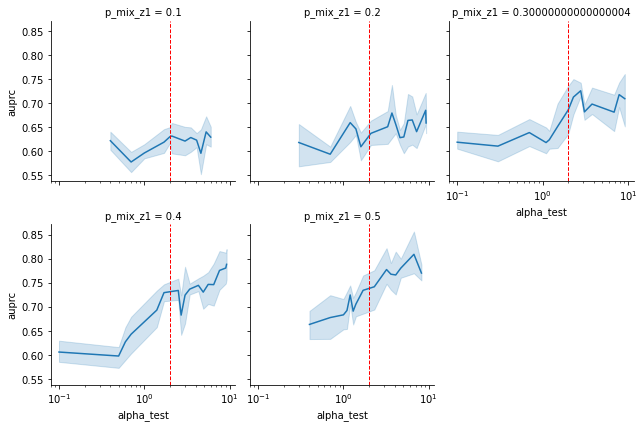

In [51]:
tmp = plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

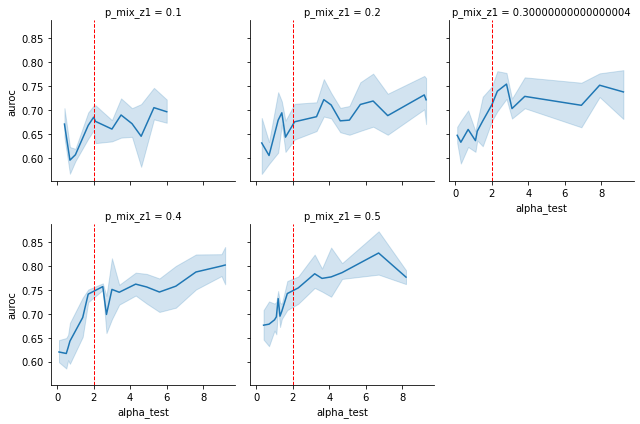

In [52]:
tmp = plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

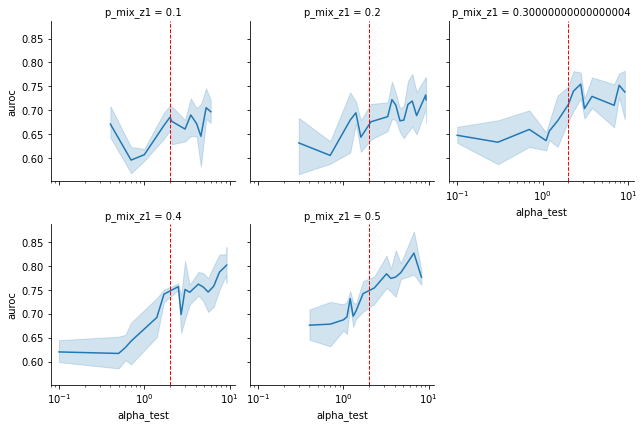

In [53]:
tmp = plotAlphaPmix(losses=losses_ls[1], alpha_train=2, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

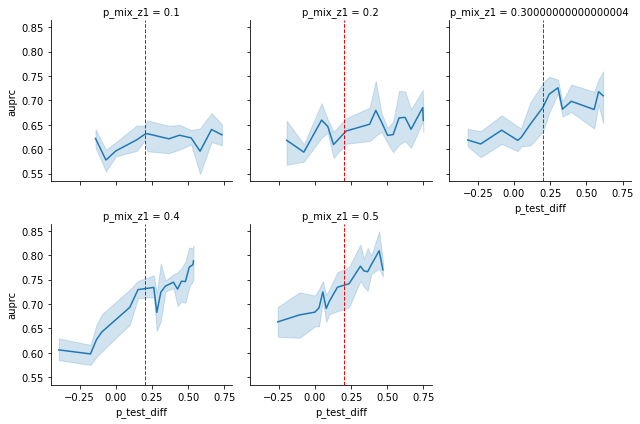

In [55]:
tmp = plotAlphaDiffPmix(losses=losses_ls[1], alpha_diff_train=0.2, key_metric="auprc")

<Figure size 864x720 with 0 Axes>

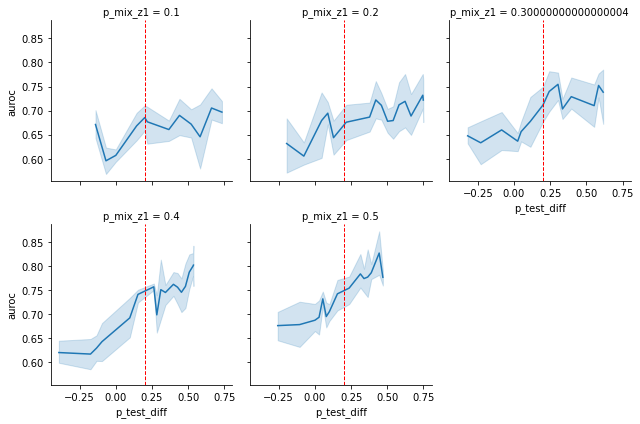

In [56]:
tmp = plotAlphaDiffPmix(losses=losses_ls[1], alpha_diff_train=0.2, key_metric="auroc")

In [57]:
tmp.query("(variable == 0) and (alpha_test == 3)")

,index,variable,value,p_mix_z1,alpha_test,p_pos_test_z0,p_pos_test_z1,p_test_diff
6,"(0.2, 0.4, 0.1, 3.0, 4, 150, 0)",0,0.679876,0.1,3.0,0.183333,0.550000,0.366667
50,"(0.2, 0.4, 0.4, 3.0, 4, 150, 0)",0,0.705688,0.4,3.0,0.155556,0.466667,0.311111


Text(0, 0.5, 'p_pos_test')

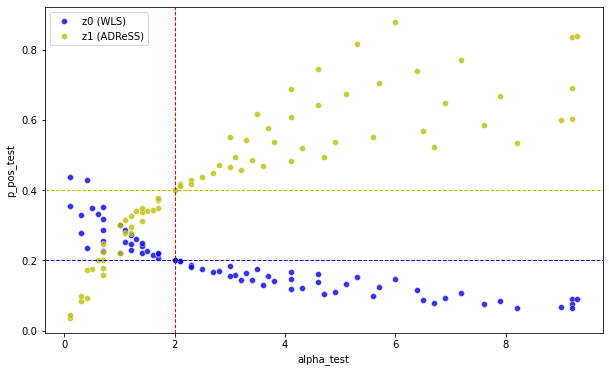

In [58]:
fig, ax = plt.subplots(figsize=(10,6))


sns.scatterplot(x="alpha_test", y="p_pos_test_z0", data=tmp[tmp['variable']==0], color="b", ax=ax, label="z0 (WLS)", alpha=0.8)
sns.scatterplot(x="alpha_test", y="p_pos_test_z1", data=tmp[tmp['variable']==0], color="y", ax=ax, label="z1 (ADReSS)", alpha=0.8)

ax.axhline(y=0.2, c="b", ls="--", linewidth=1)
ax.axhline(y=0.4, c="y", ls="--", linewidth=1)

ax.axvline(x=2, c="r", ls="--", linewidth=1)

ax.set_ylabel("p_pos_test")

### Setting 2: 0.3 vs 0.6

<Figure size 864x720 with 0 Axes>

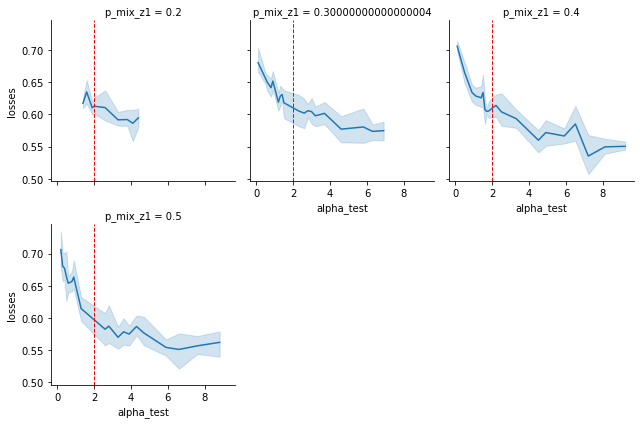

In [59]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='losses')

<Figure size 864x720 with 0 Axes>

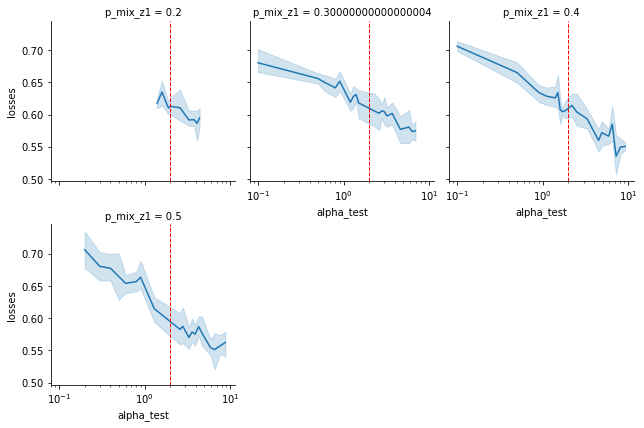

In [60]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

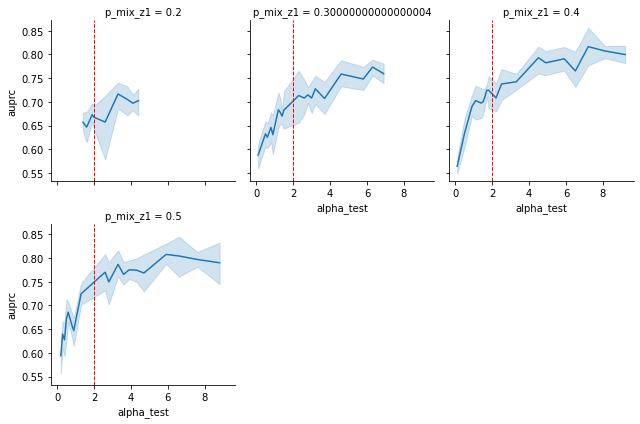

In [61]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

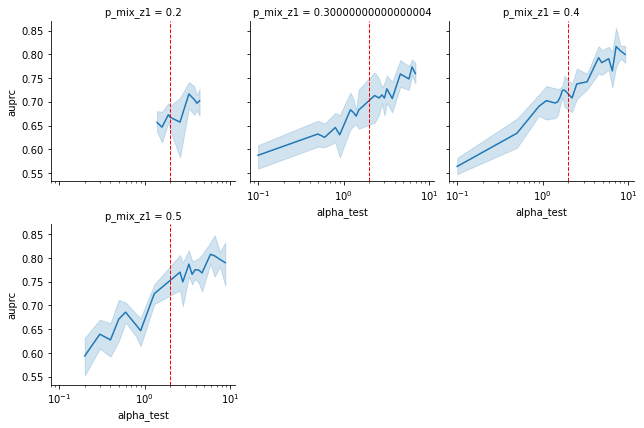

In [62]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

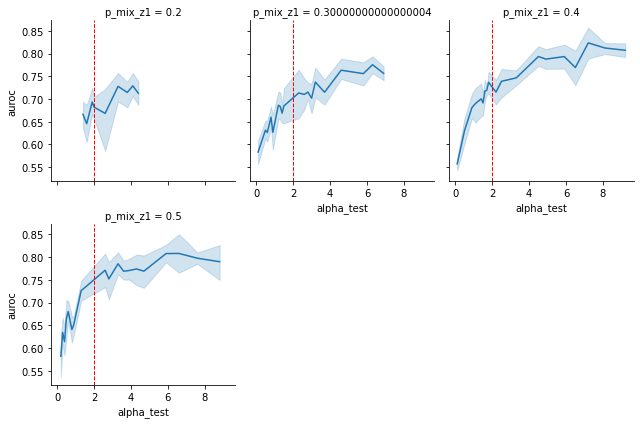

In [63]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

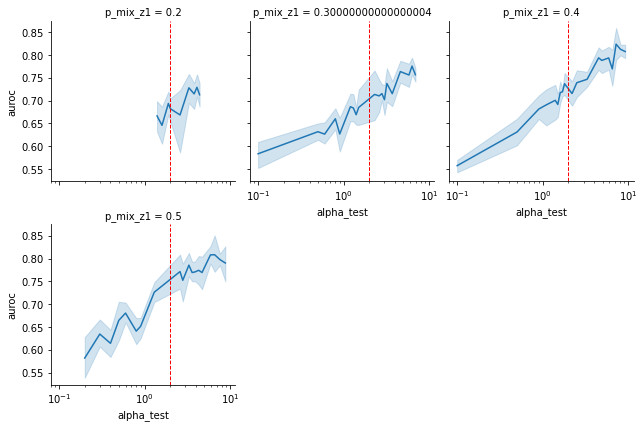

In [64]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

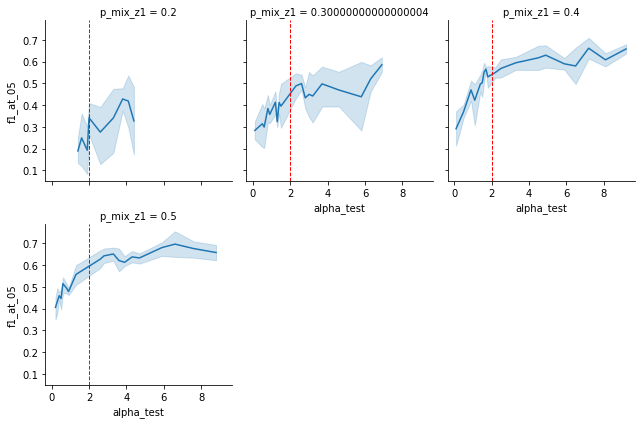

In [65]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='f1_at_05')

<Figure size 864x720 with 0 Axes>

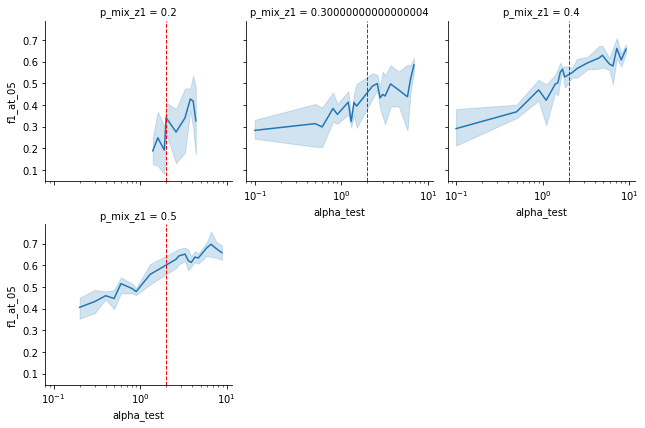

In [66]:
tmp = plotAlphaPmix(losses=losses_ls[2], alpha_train=2, key_metric='f1_at_05', logx=True)

### testing

In [69]:
tmp = pd.DataFrame.from_dict({c:losses_dict['losses'][idx] for idx,c in enumerate(losses_dict['combination'])},
                             orient="index"
                            )
tmp = tmp.reset_index()

tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])



tmp['alpha_test'] = tmp['alpha_test'].round(1) # for
tmp['p_mix_z1'] = tmp['p_mix_z1'].round(1) # for

[Text(0, 0.5, 'Losses')]

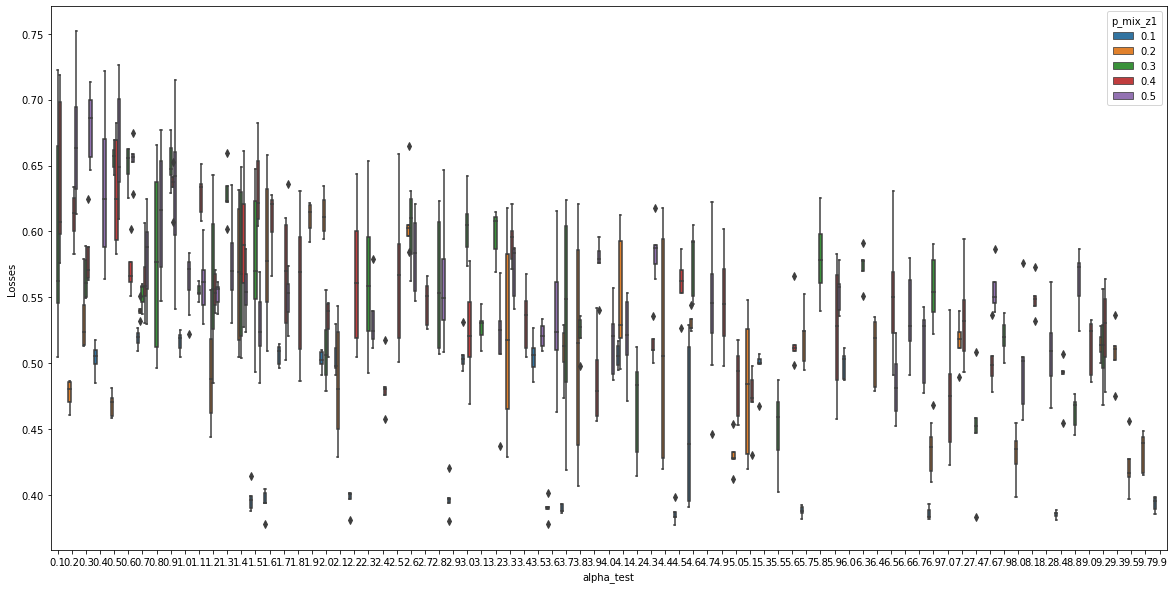

In [70]:


plt.figure(figsize=(20,10))
ax = sns.boxplot(x='alpha_test',y='value', 
            hue='p_mix_z1',
            data=tmp)
ax.set(ylabel="Losses")

In [71]:
np.array(losses_dict['combination'])[:,(2,3)]

array([[0.1, 1.5],
       [0.1, 1.6],
       [0.1, 2.2],
       [0.1, 2.9],
       [0.1, 3.6],
       [0.1, 3.7],
       [0.1, 4.5],
       [0.1, 4.6],
       [0.1, 5.7],
       [0.1, 6.9],
       [0.1, 8.4],
       [0.1, 9.9],
       [0.2, 0.2],
       [0.2, 0.5],
       [0.2, 1.2],
       [0.2, 2.1],
       [0.2, 3.3],
       [0.2, 3.8],
       [0.2, 4.4],
       [0.2, 5. ],
       [0.2, 5.1],
       [0.2, 6.9],
       [0.2, 8. ],
       [0.2, 9.5],
       [0.2, 9.7],
       [0.3, 0.1],
       [0.3, 0.8],
       [0.3, 1.2],
       [0.3, 1.4],
       [0.3, 2. ],
       [0.3, 3.7],
       [0.3, 4.2],
       [0.3, 5.5],
       [0.3, 7.4],
       [0.3, 8.8],
       [0.4, 0.1],
       [0.4, 0.2],
       [0.4, 0.3],
       [0.4, 0.7],
       [0.4, 1.2],
       [0.4, 1.8],
       [0.4, 2. ],
       [0.4, 2.2],
       [0.4, 2.4],
       [0.4, 3.9],
       [0.4, 5. ],
       [0.4, 5.1],
       [0.4, 5.9],
       [0.4, 7. ],
       [0.4, 8.4],
       [0.5, 0.2],
       [0.5, 0.7],
       [0.5,

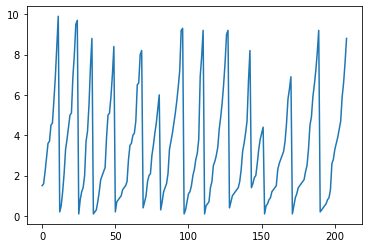

In [73]:

plt.plot(np.array(losses_dict['combination'])[:,3])

In [74]:
np.array(losses_dict['combination'])[:,2][:3]

array([0.1, 0.1, 0.1])